In [1]:
import numpy as np
import scipy.linalg as linalg
from JSAnimation import IPython_display
import matplotlib.pyplot as plt
from matplotlib import animation
from multiprocessing import Pool, Manager, Process,TimeoutError
import time
import os

In [2]:
def generate_artificial_flow(size,p,T,omega):
    v_x,v_y = np.zeros(size),np.zeros(size);
    for x in range(size[0]):
        for y in range(size[1]):
            A = np.array([[-f,0,x],[0,-f,y]])
            B = np.array([[(x*y)/f, -(f + (x*x)/f), y],[f + (y*y)/f, -(x*y)/f, -x]])
            v_x[x,y],v_y[x,y] = np.dot(A,T)/p[x,y] + np.dot(B,omega)
    return v_x, v_y
    

In [3]:
def sample_T(): #to get a systematic number of T's (use for ||n later)
    for theta in np.arange(0,np.pi,0.01):
        for phi in np.arange(0,np.pi,0.01):
            x = np.cos(theta)*np.sin(phi)
            y = np.sin(theta)*np.sin(phi)
            z = np.cos(phi)
    return np.array([[x],[y],[z]])

def calculate_perp_CT(sample_points, T): #input the presampled sample points - can be precalculated
    N = np.shape(sample_points)[0]; #justincase
    A_T = np.zeros([2*N,N]) #preallocate ndarrays for storing the matrices
    B = np.zeros([2*N,3])
    
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        
        #calculating A_T
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        A_T[2*i,i], A_T[2*i+1,i] = AtimesT[0], AtimesT[1]
        
        #calculating B
        B[2*i] = np.array([(x*y)/f, -(f + (x*x)/f), y])
        B[2*i+1] = np.array([f + (y*y)/f, -(x*y)/f, -x])
    return linalg.orth(np.concatenate((A_T,B),axis=1))

def calculate_ET(sample_points):
    N = np.shape(sample_points)[0];
    search_range = np.arange(0,np.pi,0.01)
    pool = Pool(CPU_NUMBER)
    
    def foo(T):
        return(calculate_perp_CT(sample_points,T))
    
    ET = pool.map(foo,search_range)
    pool.close()
    pool.join()

In [51]:
size = (100,100)
p = np.zeros(size) + 45
p[:,30:40] = p[:,80:90] = 15
p[45:55,45:55] = 30
p[26:39,56:69] = 40
p[53:76,53:76] = 20
T = np.array([[0],[1],[0]])
omega = np.array([[0],[0],[0]])
f = 30

v_x,v_y = generate_artificial_flow(size,p,T,omega)

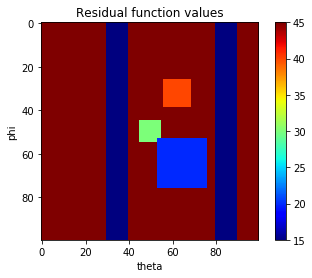

In [52]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('theta')
ax.set_ylabel('phi')
im = ax.imshow(p, cmap="jet")
fig.colorbar(im)
ax.set_title('Residual function values')

In [53]:
%%time
x_lim = size[0]
y_lim = size[1]
N = 10 #number of random points
f = 15 #focal length
search_range = np.arange(0,np.pi,0.01)
E = np.zeros((np.size(search_range),np.size(search_range)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 251 µs


In [54]:
x_lim = size[0]
y_lim = size[1]
N = 10 #number of random points
f = 15 #focal length
search_range = np.arange(0,np.pi,0.01)
E = np.zeros((np.size(search_range),np.size(search_range)))

sample_points = np.transpose([np.random.randint(0,size[0],size=N),np.random.randint(0,size[1],size=N)])
sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]


In [57]:
sample_v_x, sample_v_y, sample_points


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-0.66666667, -0.66666667, -0.66666667, -1.        , -0.66666667,
        -2.        , -0.66666667, -0.66666667, -0.66666667, -0.66666667]),
 array([[29, 26],
        [88,  2],
        [65, 96],
        [46, 46],
        [12, 50],
        [ 7, 39],
        [94, 52],
        [90, 42],
        [89, 13],
        [17, 19]]))

In [85]:
def calculate_CT_estimate(sample_points, T): #input the presampled sample points - can be precalculated
    N = np.shape(sample_points)[0]; #justincase
    A_T = np.zeros([2*N,N]) #preallocate ndarrays for storing the matrices
    B = np.zeros([2*N,3])
    
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        
        #calculating A_T
        A = np.array([[-f,0,x],[0,-f,y]])
        AtimesT = np.dot(A,T)
        A_T[2*i,i], A_T[2*i+1,i] = AtimesT[0], AtimesT[1]
        
        #calculating B
        B[2*i] = np.array([(x*y)/f, -(f + (x*x)/f), y])
        B[2*i+1] = np.array([f + (y*y)/f, -(x*y)/f, -x])
    return np.concatenate((A_T,B),axis=1)

def calculate_q(sample_points, omega, p):
    depths = np.transpose([p[sample_points[:,0],sample_points[:,1]]])
    return np.vstack((depths,omega))
    
    

In [86]:
CT = calculate_CT_estimate(sample_points, T)
q = calculate_q(sample_points,omega,p)

In [91]:
np.dot(CT,q)

array([[   0.],
       [-675.],
       [   0.],
       [-675.],
       [   0.],
       [-675.],
       [   0.],
       [-450.],
       [   0.],
       [-675.],
       [   0.],
       [-225.],
       [   0.],
       [-675.],
       [   0.],
       [-675.],
       [   0.],
       [-675.],
       [   0.],
       [-675.]])

In [92]:
v_t

array([[ 0.        ],
       [-0.66666667],
       [ 0.        ],
       [-0.66666667],
       [ 0.        ],
       [-0.66666667],
       [ 0.        ],
       [-1.        ],
       [ 0.        ],
       [-0.66666667],
       [ 0.        ],
       [-2.        ],
       [ 0.        ],
       [-0.66666667],
       [ 0.        ],
       [-0.66666667],
       [ 0.        ],
       [-0.66666667],
       [ 0.        ],
       [-0.66666667]])

In [65]:
q = np.vstack((p[sample_points[:,0],sample_points[:,1]],omega)).reshape((-1),order='F').reshape(1,2*N) #v is concat of all sample point vels 

(10,)

In [ ]:
CT = calculate_CT_estimate(sample_points, T)
q = calculate_q(sample_points,omega,p)
E_T = (np.linalg.norm(np.dot(v_t,perp_CT)))**2
E[idtheta,idphi] = E_T

In [ ]:
%%time
for idtheta,theta in enumerate(list(search_range)):
    for idphi,phi in enumerate(list(search_range)):
        x = np.cos(theta)*np.sin(phi)
        y = np.sin(theta)*np.sin(phi)
        z = np.cos(phi)
        T = np.array([[x],[y],[z]])

        perp_CT = calculate_perp_CT(sample_points, T)
        v_t = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(1,2*N) #v is concat of all sample point vels 
        E_T = (np.linalg.norm(np.dot(v_t,perp_CT)))**2
        E[idtheta,idphi] = E_T

theta, phi = np.unravel_index(E.argmin(), E.shape)
x_final = np.cos(theta)*np.sin(phi)
y_final = np.sin(theta)*np.sin(phi)
z_final = np.cos(phi)
T_final = np.array([[x],[y],[z]])
print(T)

In [ ]:
print(E.min())

In [ ]:
#plotting residual surfaces
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('theta')
ax.set_ylabel('phi')
im = ax.imshow(E, cmap="jet")
fig.colorbar(im)
ax.set_title('Residual function values')